In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('hanoi_quality.csv')
df1=df.reset_index()['pm25']

In [3]:
def smoothed(data):
    # Apply moving average filter to smooth the forecasted values
    window_size = 5  # You can adjust the window size as needed
    data_smoothed = data.rolling(window=window_size).mean()

    # Interpolate NaN values resulting from the moving average
    data_smoothed_interpolated = data_smoothed.interpolate()

    # Fill remaining NaN values
    data_smoothed_filled = data_smoothed_interpolated.fillna(method='bfill')  # or 'ffill', or use fillna(value=0)

    return data_smoothed_filled

In [4]:
df1= smoothed(df1)
print(df1)

0       64.6
1       64.6
2       64.6
3       64.6
4       64.6
        ... 
1915    62.4
1916    54.2
1917    55.8
1918    59.4
1919    67.2
Name: pm25, Length: 1920, dtype: float64


In [5]:
df1.shape

(1920,)

In [6]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [8]:
print(train_size)
print(test_size)

1728
192


In [9]:
print(train_data.shape)
print(test_data.shape)


(1728, 1)
(192, 1)


In [10]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [11]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)


(1627, 100)
(1627,)
(91, 100)
(91,)


In [13]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [14]:
print(X_train.shape)
print(X_test.shape)

(1627, 100, 1)
(91, 100, 1)


In [15]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [16]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - loss: 0.2285
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0302
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0206
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0165
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0135
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0107
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0086
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0079
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0069
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0061
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0055
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0055
Epoch 13/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0047
Epoch 14/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0043
Epoch 15/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - l

In [17]:
# 10. Dự báo dữ liệu test,
train_predict=model.predict(X_train)
y_pred=model.predict(test_data.reshape(test_data.shape[0],test_data.shape[1] , 1))


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [18]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)


In [19]:
y_pred = pd.DataFrame(y_pred, columns=['pm25'])
y_pred = smoothed(y_pred)
y_pred = y_pred.to_numpy()

In [20]:
ytest=scaler.inverse_transform(test_data)
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(ytest - y_pred)/np.abs(ytest))*100

print('Testing MAPE:', test_mape)

# Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 42.881816773478974
Testing MAPE: 45.890630030395144
Testing MAE: 39.47467592557272


In [21]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape

(1, 132)

In [22]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<90):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


(1, 132)
[0.32288134]
133
1 day input [0.43801653 0.39197166 0.47107438 0.52656434 0.53719008 0.50885478
 0.56552538 0.64817001 0.71782763 0.7863046  0.85242031 0.78984652
 0.67178276 0.54309327 0.43565525 0.35419126 0.34828808 0.35419126
 0.44391972 0.45808737 0.50177096 0.50649351 0.49940968 0.42857143
 0.46044864 0.43211334 0.43801653 0.43565525 0.42739079 0.38016529
 0.35773318 0.39079103 0.36835891 0.32467532 0.30578512 0.27863046
 0.26682409 0.28689492 0.29634002 0.32231405 0.41676505 0.48642267
 0.6540732  0.79693034 0.85242031 0.90318772 0.91381346 0.7579693
 0.64817001 0.66824085 0.6068477  0.52302243 0.57497048 0.57378985
 0.49350649 0.43447462 0.41322314 0.38842975 0.45572609 0.49350649
 0.50295159 0.51121606 0.49232586 0.42502952 0.4025974  0.41794569
 0.45572609 0.49232586 0.53482881 0.56434475 0.58087367 0.59031877
 0.58677686 0.53955136 0.47461629 0.42975207 0.35064935 0.32585596
 0.36127509 0.38842975 0.39669421 0.40850059 0.39079103 0.30224321
 0.39197166 0.33766234 0.

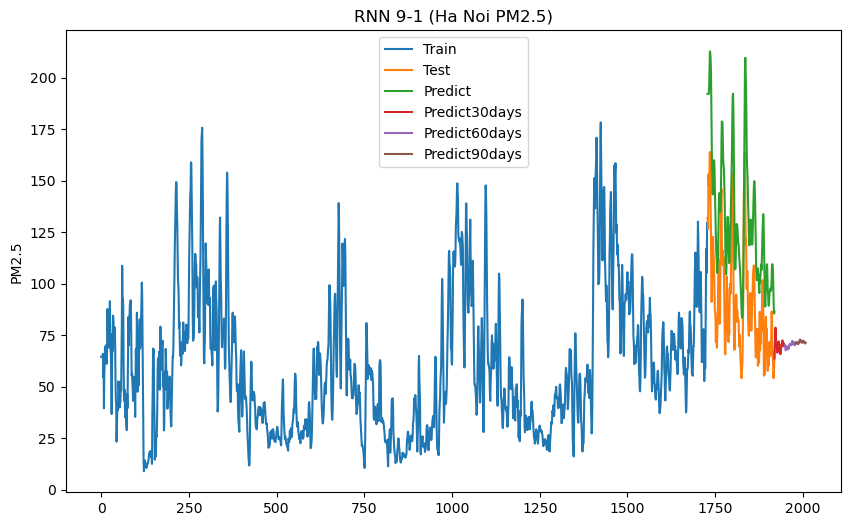

In [23]:
# Define the indices
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot train data
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

# Plot test data and predictions
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')
plt.plot(test_data_index, y_pred, label='Predict')

# Plot predictions for future data in 30-day intervals
for i in range(3):
    start_idx = len(df1) + (i * 30) - 1
    end_idx = start_idx + 30
    plt.plot(pd.RangeIndex(start=start_idx, stop=end_idx, step=1),
             scaler.inverse_transform(lst_output[i*30:(i+1)*30]),
             label=f'Predict{i*30+30}days')

# Add legend and labels
plt.legend()
plt.title('RNN 9-1 (Ha Noi PM2.5)')
plt.ylabel('PM2.5')
plt.show()

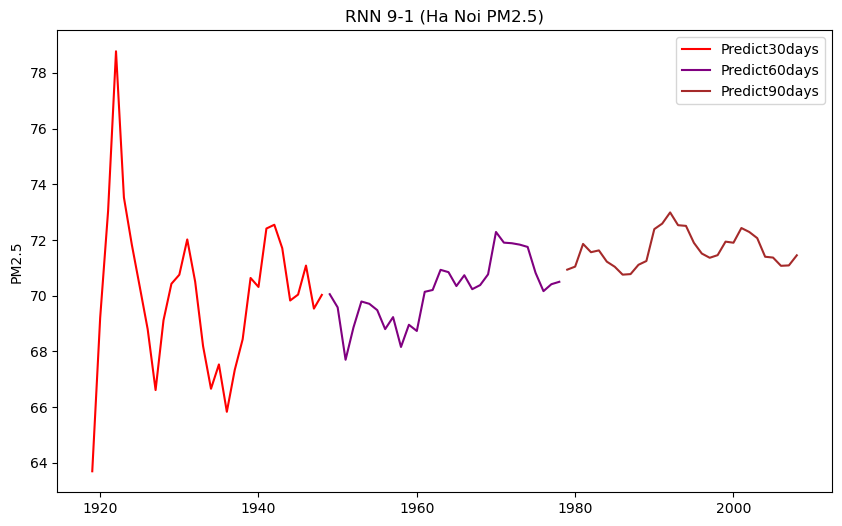

In [24]:
plt.figure(figsize=(10, 6))

# Plot predictions for future data in 30-day intervals with specified colors
colors = ['red', 'purple', 'brown']
for i in range(3):
    start_idx = len(df1) + (i * 30) - 1
    end_idx = start_idx + 30
    plt.plot(pd.RangeIndex(start=start_idx, stop=end_idx, step=1),
             scaler.inverse_transform(lst_output[i*30:(i+1)*30]),
             label=f'Predict{i*30+30}days',
             color=colors[i])

# Add legend and labels
plt.legend()
plt.title('RNN 9-1 (Ha Noi PM2.5)')
plt.ylabel('PM2.5')
plt.show()